**Qustion: Can IMU data of a frame be used to predict the active duty cycles (meaningful states detected)?** 

Here we treat it as a binary classification problem.  IMU data -> active cycle (T/F)

In [1]:
from __future__ import absolute_import, division, print_function

import collections
import glob
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import sqlalchemy as sa

from rmexp import dbutils, config
from rmexp.schema import models

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from scipy.ndimage.filters import gaussian_filter1d

/home/junjuew/work/resource-management/conda-env-rmexp/lib/python2.7/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [3]:
def insert_or_update_one(sess, model, keys_dict, vals_dict):
    record = sess.query(model).filter_by(**keys_dict).one_or_none()
    if record is not None:
        record.update(vals_dict)
    else:
        create_dict = {}
        create_dict.update(keys_dict)
        create_dict.update(vals_dict)
        record = model(**create_dict)
        sess.add(record)
    return record

In [34]:
## settings for Lego
# APP = "lego"
# TRAIN_TRACES = ['lego-tr' + str(i) for i in (1, 2, 3, 4)]
# TEST_TRACES = ['lego-tr' + str(i) for i in (6, 7, 8)]
# def active_fn(df):
#     return ss_df['val'].str.contains('\[\[')

## settings for Ping Pong
APP = "pingpong"
TRAIN_TRACES = ['pingpong-tr' + str(i) for i in (1, 2, 3)]
TEST_TRACES = ['pingpong-tr' + str(i) for i in (4, 5)]
def filter_active(ss_df):
    return ~(ss_df['val'].str.contains('Cannot find table')
            | ss_df['val'].str.contains('Detected table too small')
            | ss_df['val'].str.contains('Table top line')
            | ss_df['val'].str.contains('Table doesn\'t occupy')
            | ss_df['val'].str.contains('Angle between two side')
            | ss_df['val'].str.contains('Valid area too small')
           )

In [20]:
# load IMU csv files into MySQL

def load_IMU_to_DB(trace_name, base_dir):
    trace_num = re.search('\d+', trace_name).group(0)
    csv_name = glob.glob(os.path.join(base_dir,
                                      trace_num, '*.csv'))[0]
    print("Using file as IMU data:", csv_name)
    df = pd.read_csv(csv_name,index_col='frame_id')
    df['sensor_timestamp'] = pd.to_datetime(df['sensor_timestamp'])
    
    new = 0
    for row in df.itertuples():
        keys_dict = {'name': trace_name,
                     'trace': trace_num,
                     'index': row.Index
                    }
        vals_dict = {'sensor_timestamp': row.sensor_timestamp.to_pydatetime(),
                     'rot_x': row.rot_x,
                     'rot_y': row.rot_y,
                     'rot_z': row.rot_z,
                     'acc_x': row.acc_x,
                     'acc_y': row.acc_y,
                     'acc_z': row.acc_z
                    }
        
        insert_or_update_one(sess, models.IMU, keys_dict, vals_dict)

    print("Updated: ", len(sess.dirty))
    print("New: ", len(sess.new))
    sess.commit()

# sess = dbutils.get_session()
# for trace_name in TRAIN_TRACES + TEST_TRACES:
#     load_IMU_to_DB(trace_name, '/home/junjuew/work/resource-management/data/pingpong-trace')
# sess.close()

In [21]:
# calibration data using zero-movement readings
#  select avg(rot_x), avg(rot_y), avg(rot_z), avg(acc_x), avg(acc_y), avg(acc_z) from IMU where name = "lego-tr0";
IMU_CALIBRATE = [0.0006005733204134366, -0.0010699289405684755, 0.0010396479328165374,
                -0.4246709463824289, 10.076913759689923, 0.31374152131782945]

# the -tr0 IMU readings from lego and pingpong are quite different ...

In [22]:
# reading from MySQL using Pandas API

def get_SS_pd(trace_name):
    df = pd.read_sql('SELECT * FROM SS WHERE name = %s', dbutils.engine, params=[trace_name,])
    df['index'] = df['index'].astype(int) - 1   # SS's index counts from 1
    df = df.sort_values('index')
    return df
    
def get_IMU_pd(trace_name):
    df = pd.read_sql('SELECT * FROM IMU WHERE name = %s', dbutils.engine, params=[trace_name,])
    df['index'] = df['index'].astype(int)
    df = df.sort_values('index')
    return df

In [32]:
# Classifiction problem: 
# Features: 6 IMU readings per frame -> transform_func -> X
# Label y: 0 - passive, 1 - active.
# use SVM with GridSearch

def get_raw_Xy(trace, calibrate=True):
    imu_df = get_IMU_pd(trace)
    ss_df = get_SS_pd(trace)
    
    # SS sometimes has one more frame than IMU, drop it
    ss_df = ss_df[ss_df['index'] <= imu_df['index'].max()]
    
    use_imu_cols = ['rot_x','rot_y','rot_z','acc_x','acc_y','acc_z']
    X1 = imu_df[use_imu_cols].values
    if calibrate:
        # adjust for calibration
        X1 = X1 - np.array(IMU_CALIBRATE)
    
    y1 = np.zeros_like(X1[:, 0])
    active_inds = ss_df[filter_active(ss_df)]['index'].values
    y1[active_inds] = 1 
    print("%s has %d/%d active/total frames" % (trace, np.count_nonzero(y1), y1.shape[0]))
    return X1, y1


def train_clf(trace_names, 
              svm_kargs={}, 
              X_transform_func=lambda x: x, 
              param_grid = {'svm__C': [1., 10.], 'svm__kernel': ['rbf', 'linear']}):
    Xs = []
    ys = []
    
    for trace in trace_names:
        X1, y1 = get_raw_Xy(trace)
        X1 = X_transform_func(X1)
        Xs.append(X1)
        ys.append(y1)
    
    X = np.vstack(Xs)
    y = np.concatenate(ys)
    print(X.shape)
    print("Total frames: ", X.shape[0], "Active frames: ", np.count_nonzero(y))
    
    clf = Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('svm', SVC(**svm_kargs)),
    ])
     
    clf = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=4)

    clf.fit(X, y)
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
#     print("Training confusion matrix:\n", cm)
    return clf, cm, (X, y, y_pred)

def eval_clf(clf, trace_names, X_transform_func=lambda x:x):
    Xs = []
    ys = []
    for trace in trace_names:
        X1, y1 = get_raw_Xy(trace)
        X1 = X_transform_func(X1)
        Xs.append(X1)
        ys.append(y1)
        
    X = np.vstack(Xs)
    y = np.concatenate(ys)
    
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return cm, (X, y, y_pred)

In [24]:
# manually engineered features
# select acc_x, acc_y, Gaussian smooth, and substract cummulative mean

def past_windowed_1d(x, size, func):
    # output[i] -> func(x[i-size+1:i+1])
    # aka windowed function on the past `size` frames
    # should only call on one trace
    assert x.ndim == 1
    rv = []
    for i in range(x.shape[0]):
        wind = x[max(0, i - size + 1): i+1]  # including i
        rv.append(func(wind))
        
    return np.array(rv)

def transform_acc_x(X_imu6):
    accx = X_imu6[:,3]  # acc_x
    accy = X_imu6[:,4] # acc_y
    accz = X_imu6[:,4] # acc_z
    
    accx_smooth_mean = past_windowed_1d(accx, accx.shape[0],
                                   lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))
    accy_smooth_mean = past_windowed_1d(accy, accy.shape[0],
                                   lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))
    accz_smooth_mean = past_windowed_1d(accz, accz.shape[0],
                                   lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))
    
    X_combined = np.stack([accx_smooth_mean, accy_smooth_mean, accz_smooth_mean], axis=1)
    return X_combined

In [33]:
# tune weight of label 1 to trade off FN and FP
# on average 30% frames are active for Lego

weights = np.arange(24., 30., 2.)
result_df = pd.DataFrame()

for w in weights:
    print("weight:", w)
    svm_kargs = {'class_weight': {0: 1.0, 1: w}, 'random_state': 42}
    clf, cm, _ = train_clf(TRAIN_TRACES, X_transform_func=transform_acc_x, svm_kargs=svm_kargs)
    cm, _ = eval_clf(clf, TEST_TRACES, X_transform_func=transform_acc_x)
    print("Eval cm:\n", cm)
    result_df = result_df.append({'weight': w, 'confusion_matrix': cm, 'params': clf.best_params_}, ignore_index=True)

print(result_df)

weight: 24.0
pingpong-tr1 has 661/1359 active/total frames
pingpong-tr2 has 1127/2567 active/total frames
pingpong-tr3 has 546/1336 active/total frames
(5262, 3)
Total frames:  5262 Active frames:  2334
pingpong-tr4 has 1566/2694 active/total frames
pingpong-tr5 has 1018/2132 active/total frames
Eval cm:
 [[ 250 1992]
 [  80 2504]]
weight: 26.0
pingpong-tr1 has 661/1359 active/total frames
pingpong-tr2 has 1127/2567 active/total frames
pingpong-tr3 has 546/1336 active/total frames
(5262, 3)
Total frames:  5262 Active frames:  2334
pingpong-tr4 has 1566/2694 active/total frames
pingpong-tr5 has 1018/2132 active/total frames
Eval cm:
 [[ 238 2004]
 [  78 2506]]
weight: 28.0
pingpong-tr1 has 661/1359 active/total frames
pingpong-tr2 has 1127/2567 active/total frames
pingpong-tr3 has 546/1336 active/total frames
(5262, 3)
Total frames:  5262 Active frames:  2334
pingpong-tr4 has 1566/2694 active/total frames
pingpong-tr5 has 1018/2132 active/total frames
Eval cm:
 [[ 237 2005]
 [  78 2506]

In [35]:
# Retrain using a chosen trade-off
clf, cm, _ = train_clf(TRAIN_TRACES, 
                        X_transform_func=transform_acc_x,
                        svm_kargs={'class_weight': {0: 1.0, 1: 26.}, 'random_state': 42, 'verbose': True},
                        param_grid = {'svm__C': [1.,], 'svm__kernel': ['rbf',]})
clf = clf.best_estimator_
with open('IMU_' + APP + '_clf.pkl', 'w') as f:
    pickle.dump(clf, f)
print("OK")

pingpong-tr1 has 661/1359 active/total frames
pingpong-tr2 has 1127/2567 active/total frames
pingpong-tr3 has 546/1336 active/total frames
(5262, 3)
Total frames:  5262 Active frames:  2334
[LibSVM]OK


In [38]:
# Impact on latency of detecting state change compared to oracle
def get_state_change_frames(ss_df, k=5):
    # returns dict(ss -> first detection of change)
    # require k consecutive frames to declare state change

    ss_df = ss_df.reset_index(drop=True)  # reset Index to row id
    state_change = dict()
    
    cur_state = None
    cur_count = 0
    
    # only count "useful" SS
    for r in ss_df.itertuples():
        ss, frame_id = r.val, r.index
        if ss not in state_change and '[[' in ss:
            if ss == cur_state:
                cur_count += 1
                if cur_count >= k:
                    state_change[ss] = frame_id # commit
            else:
                cur_state = ss # change tracking state
                cur_count = 0
        else:
            cur_state = None
            cur_count = 0
    
    return state_change


def compare_state_change_latency(gt_dict, test_dict):
    return dict([(k, test_dict.get(k, float('inf')) - gt_dict[k]) for k in gt_dict])
            
    
def eval_load_and_latency(traces, clf):
    df = pd.DataFrame()
    for trace_name in traces:
        print(trace_name)
        ss_df = get_SS_pd(trace_name)
#         gt_state_change = get_state_change_frames(ss_df)

        cm, (_, y, y_pred) = eval_clf(clf, [trace_name,], X_transform_func=transform_acc_x)
        tn, fp, fn, tp = cm.ravel()

#         imu_filtered_df = ss_df.iloc[np.nonzero(y_pred)]
#         imu_filtered_state_change = get_state_change_frames(imu_filtered_df)

#         latency = compare_state_change_latency(gt_state_change, imu_filtered_state_change)
#         print(json.dumps(latency, indent=4))

        # plot
        plt.figure(figsize=(8, 2))
        plt.plot(y[::] + .1, 'b.', label='GT frames')
        plt.plot(y_pred[::], 'r.', label='IMU-processed frames')
#         plt.vlines(gt_state_change.values(), -.1, 1.1, 'k', label='GT State change')
#         plt.vlines(imu_filtered_state_change.values(), -.1, 1.1, 'k', linestyle='dashed',
#                    label='IMU-processed State change')
        
        plt.yticks([0, 1], ['Passive', 'Active'])
        plt.xlabel('Frame ID')
        plt.legend()
        plt.title("Ground truth vs. Processed on timeline (trace: %s)" % trace_name)

    
        df = df.append({
            'trace_name': trace_name,
            'dropped_total': 1. * (tn + fn) / (tn+fp+fn+tp),
            'dropped_active': 1. * (fn) / (tp + fn),
            'dropped_passive': 1. * (tn) / (tn + fp),
#             'change_delay_frames_mean': np.mean(latency.values()),
#             'change_delay_frames_max': np.max(latency.values())
        }, ignore_index=True)
    return df

pingpong-tr4
pingpong-tr4 has 1566/2694 active/total frames


<IPython.core.display.Javascript object>


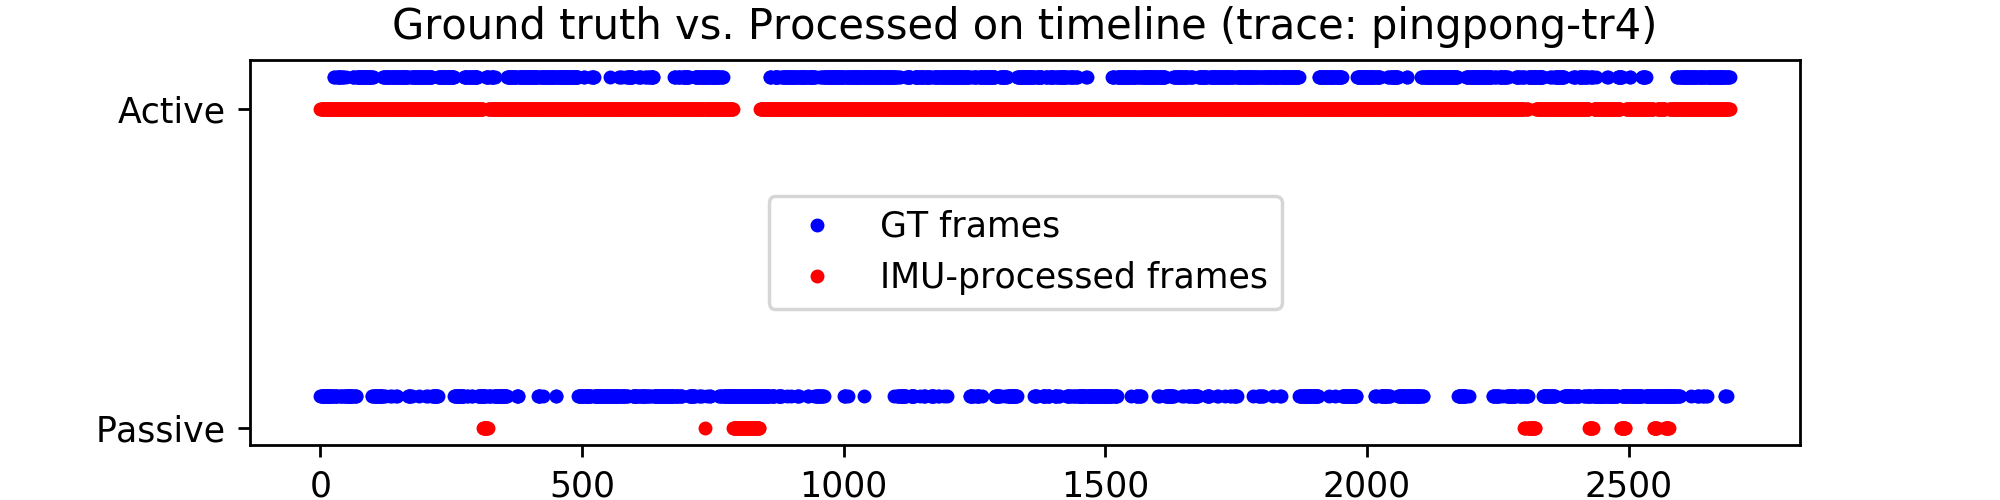

pingpong-tr5
pingpong-tr5 has 1018/2132 active/total frames


<IPython.core.display.Javascript object>


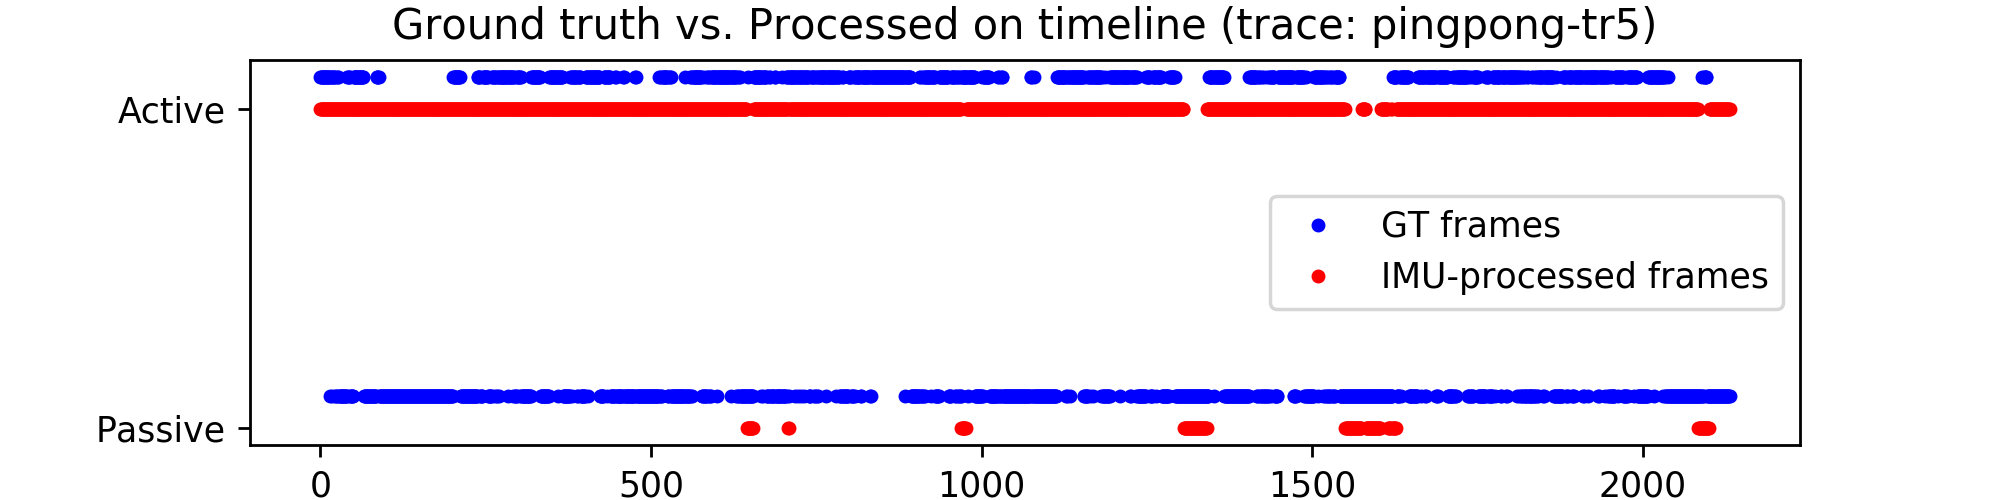

   dropped_active  dropped_passive  dropped_total    trace_name
0        0.017880         0.075355       0.041945  pingpong-tr4
1        0.019646         0.098743       0.060976  pingpong-tr5


In [39]:
%matplotlib notebook

test_set_result = eval_load_and_latency(TEST_TRACES, clf)
test_set_result.to_csv('IMU_result.txt')
print(test_set_result)

pingpong-tr1 has 661/1359 active/total frames
pingpong-tr1 has 661/1359 active/total frames


<IPython.core.display.Javascript object>


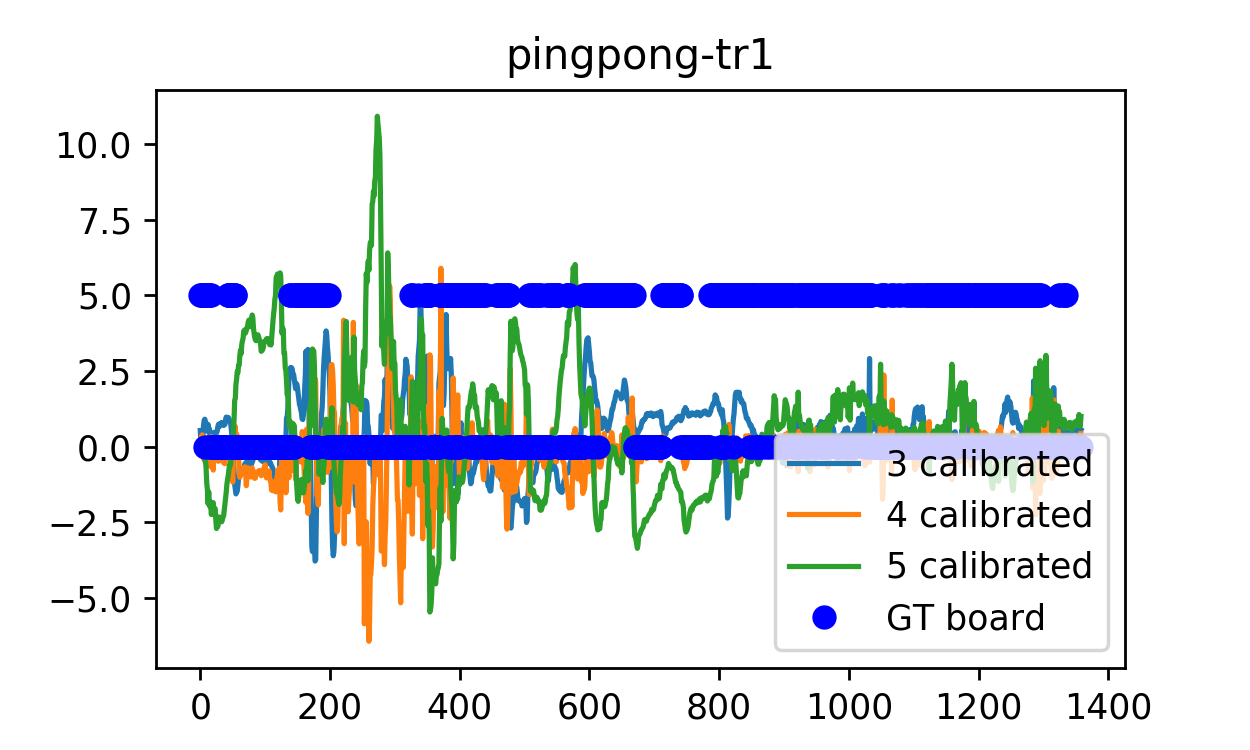

Corr coef:
 [[ 1.          0.15003885]
 [ 0.15003885  1.        ]]
pingpong-tr2 has 1127/2567 active/total frames
pingpong-tr2 has 1127/2567 active/total frames


<IPython.core.display.Javascript object>


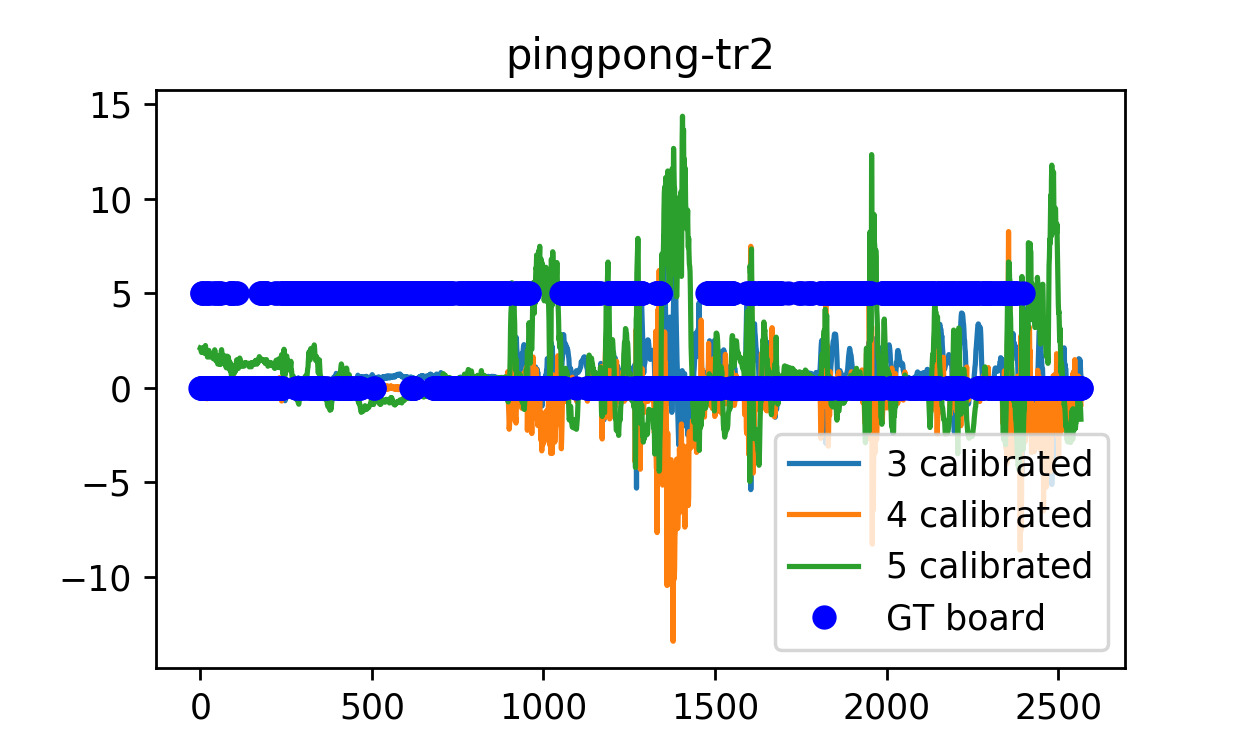

Corr coef:
 [[ 1.          0.12857547]
 [ 0.12857547  1.        ]]
pingpong-tr3 has 546/1336 active/total frames
pingpong-tr3 has 546/1336 active/total frames


<IPython.core.display.Javascript object>


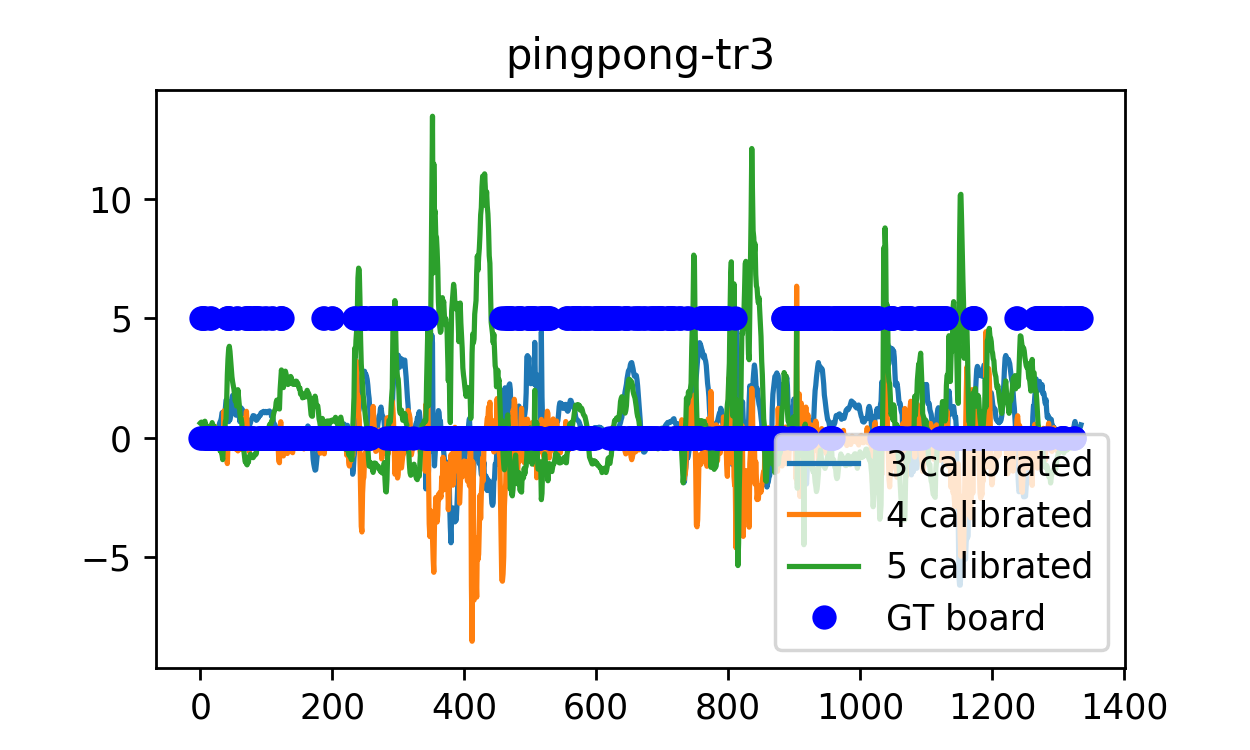

Corr coef:
 [[ 1.          0.24646149]
 [ 0.24646149  1.        ]]
pingpong-tr4 has 1566/2694 active/total frames
pingpong-tr4 has 1566/2694 active/total frames


<IPython.core.display.Javascript object>


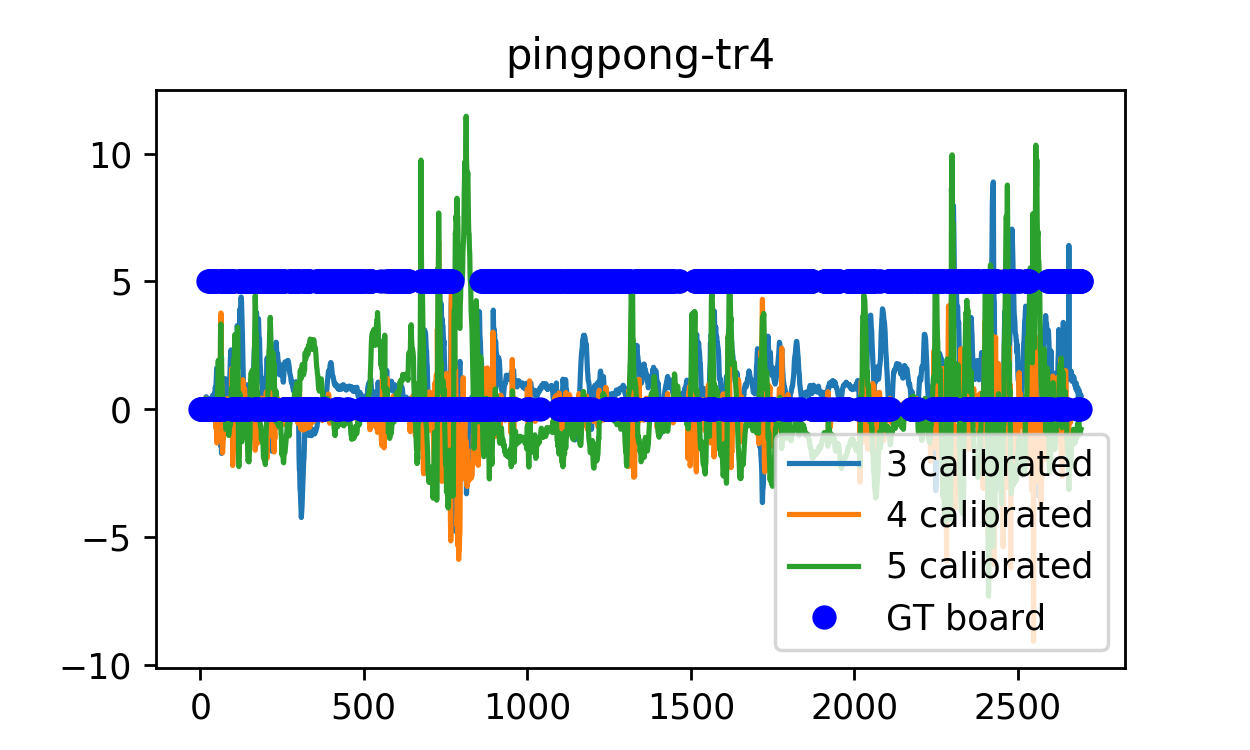

Corr coef:
 [[ 1.          0.15859716]
 [ 0.15859716  1.        ]]
pingpong-tr5 has 1018/2132 active/total frames
pingpong-tr5 has 1018/2132 active/total frames


<IPython.core.display.Javascript object>


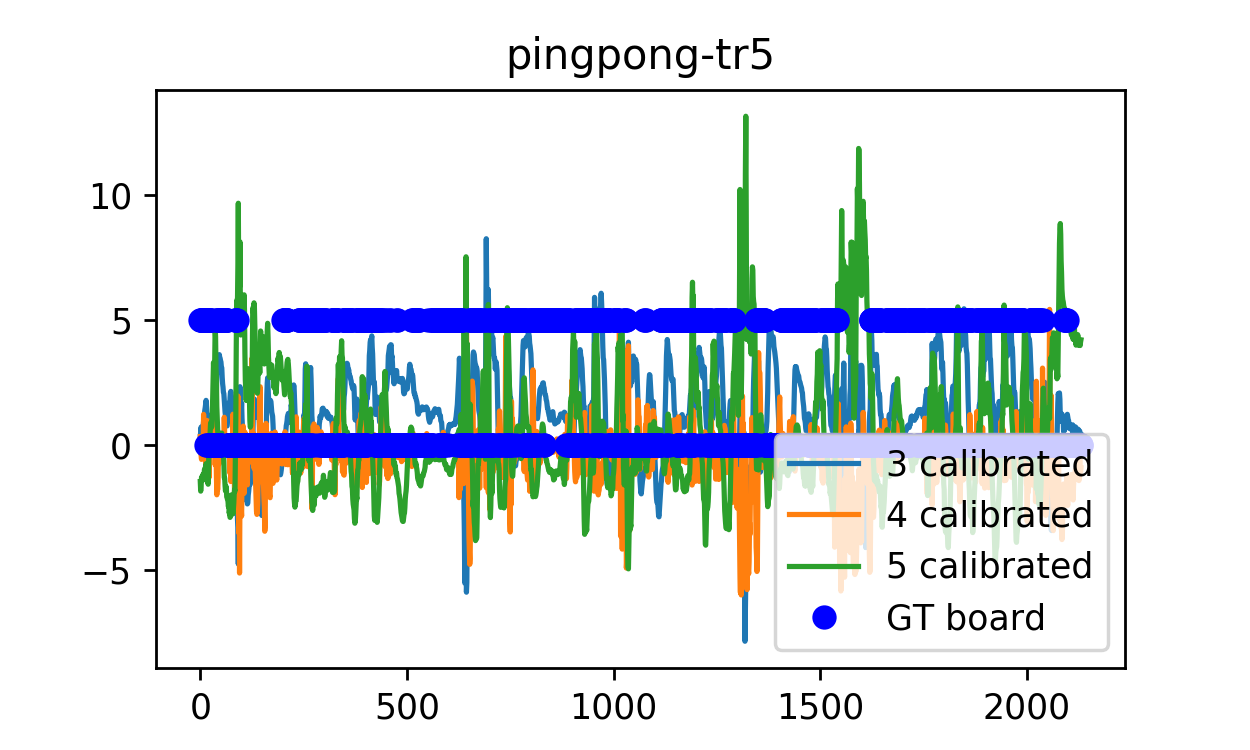

Corr coef:
 [[ 1.          0.18958183]
 [ 0.18958183  1.        ]]


In [31]:
# dirty playground
%matplotlib notebook


for trace_name in TRAIN_TRACES + TEST_TRACES:
    X, y = get_raw_Xy(trace_name)
    X_uncalibrated, _ = get_raw_Xy(trace_name, calibrate=False)

    X_accx = X[:,3]

    X_smooth = past_windowed_1d(X_accx, 90, lambda w: np.mean(w))

    X_cummin = np.minimum.accumulate(X_smooth)
    X_cummax = np.maximum.accumulate(X_smooth)
    X_cummean = np.cumsum(X_smooth) / (np.arange(X_smooth.shape[0]) + 1)

    # X_star = X_smooth - np.cumsum(X_accx) / (np.arange(X_accx.shape[0]) + 1)
    # X_star = gaussian_filter1d(X_accx,10) - np.mean(X_accx)
    X_star = past_windowed_1d(X_accx, X_accx.shape[0], lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))

    y_pred = np.array(X_star < 0.1, dtype=np.int8)

    # hot fix: always transmit first 90 frames (~3 sec)
    y_pred[:90] = 1

    fn_inds = np.nonzero(np.logical_and(y == 1, y_pred == 0))[0]
    fp_inds = np.nonzero(np.logical_and(y == 0, y_pred == 1))[0]


    if True:
        plt.figure(figsize=(5,3))

        for i in range(3, 6):
            plt.plot(X[:,i], label=str(i)+' calibrated')

        plt.plot(y*5, 'bo', label='GT board')
    #     plt.plot(X_accx, 'g', label ='acc x')

    #     plt.plot(X_smooth , 'k', label ='X smooth')
    #     plt.plot(X_cummean, 'c', label='cum mean')
    #     plt.plot(X_smooth < np.mean(X_smooth), label='offset mean')
    #     plt.plot(X_cummin, 'c', label ='X cummax')
    #     plt.plot(X_cummax, 'm', label ='X cummin')
    #     plt.plot(X_star, 'r', label ='acc x (smoothed&normalized)')
    #     plt.plot(gaussian_filter1d(X_accx,10), label='Gaussian smooth')
    #     plt.plot(fn_inds, np.ones_like(fn_inds) , 'yx', label = 'FN')
    #     plt.plot(fp_inds, np.zeros_like(fp_inds) , 'mx', label = 'FP')
        plt.legend(loc='lower right')
        plt.title(trace_name)

    print("Corr coef:\n", np.corrcoef(X_star, y))


#     ss_df = get_SS_pd(trace_name)
#     gt_state_change = get_state_change_frames(ss_df)
#     print("GT state change:",json.dumps(gt_state_change, indent=4))

#     cm = confusion_matrix(y, y_pred)
#     print("Confusion matrix:\n", cm)
#     tn, fp, fn, tp = cm.flatten()
#     print("IMU drops %d%% total frames; %d%% board frame; %d%% no-board frames"
#                % (100. *(tn + fn) / (tn+fp+fn+tp), 100. * fn / (tp + fn), 100. * tn / (tn + fp)))

#     imu_filtered_df = ss_df.iloc[np.nonzero(y_pred)]
#     imu_filtered_state_change = get_state_change_frames(imu_filtered_df)
#     #     print(json.dumps(imu_filtered_state_change, indent=4))

#     latency = compare_state_change_latency(gt_state_change, imu_filtered_state_change)
#     print("State change latency compared to oracle: mean %f, max %f" % (np.mean(latency.values()), np.max(latency.values())))
#     print(json.dumps(latency, indent=4))